# Test Case 5 - Single Inductance

In [1]:
from CircuitCalculator.Circuit.state_space_model import state_space_model_v2
from CircuitCalculator.Circuit.circuit import Circuit, transform_circuit
from CircuitCalculator.Circuit import components as cmp
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

## Setup Circuit

In [2]:
R1, R2, R3 = 10, 20, 30
L = 2
V0 = 5
circuit = Circuit([
    cmp.dc_voltage_source(id='Uq', V=V0, nodes=('1', '0')),
    cmp.resistor(id='R1', R=R1, nodes=('1', '2')),
    cmp.resistor(id='R2', R=R2, nodes=('2', '0')),
    cmp.resistor(id='R3', R=R3, nodes=('2', '3')),
    cmp.inductance(id='L', L=L, nodes=('3', '0')),
    cmp.ground(nodes=('0',))
])

In [3]:
network=transform_circuit(circuit, w=0)
network

Network(branches=[Branch(node1='1', node2='0', element=NortenElement(name='Uq', type='voltage_source', Z=0j, V=(5+0j))), Branch(node1='1', node2='2', element=NortenElement(name='R1', type='resistor', Z=10.0, V=0)), Branch(node1='2', node2='0', element=NortenElement(name='R2', type='resistor', Z=20.0, V=0)), Branch(node1='2', node2='3', element=NortenElement(name='R3', type='resistor', Z=30.0, V=0)), Branch(node1='3', node2='0', element=NortenElement(name='L', type='impedance', Z=0j, V=0))], node_zero_label='0')

In [4]:
def step(t: np.ndarray) -> np.ndarray:
    return np.heaviside(t, 1)

In [5]:
t_max = 0.3
t0 = 0.1
Ts = 0.0003
t = np.arange(0, t_max, Ts)
V = V0*step(t-t0)

In [6]:
import itertools
from CircuitCalculator.Network.NodalAnalysis.label_mapping import default_node_mapper
node_mapping = default_node_mapper(network)
def element_incidence_matrix(values: dict[str, float]) -> np.ndarray:
    Delta = np.zeros((len(values), node_mapping.N))
    for (k, value), (i_label) in itertools.product(enumerate(values), node_mapping):
        if i_label == network[value].node1:
            Delta[k][node_mapping(i_label)] = +1
        if i_label == network[value].node2:
            Delta[k][node_mapping(i_label)] = -1
    return Delta

In [7]:
from CircuitCalculator.Network.NodalAnalysis.node_analysis import *
import CircuitCalculator.Network.NodalAnalysis.label_mapping as map

l_labels = ['L']

Y = create_node_matrix_from_network(network)

source_mapping = map.default_source_mapper(network)
Q = create_source_incidence_matrix_from_network(network)
for l in l_labels:
    Q = np.delete(Q, source_mapping[l], axis=1)

Delta = np.array([[1]])

Tau = np.array([[L/R3]])

R = np.array([[R3]])
L = np.array([[L]])

A = np.linalg.inv(Delta @ np.linalg.inv(Y) @ np.linalg.inv(R) - np.eye(1)) @ np.linalg.inv(L) @ R
B = np.linalg.inv(L - Delta @ np.linalg.inv(Y) @ Tau) @ Delta @ np.linalg.inv(Y) @ Q

print(A)
print(B)

# (Delta @ np.linalg.inv(Y) @ np.linalg.inv(R) - np.eye(1)) @ L

[[-18.33333333+0.j]]
[[0.33333333+0.j]]


In [8]:
A = -(R1*R2+R1*R3+R2*R3)/(R1+R2)/L
B = R2/(R1+R2)/L
sys = signal.StateSpace(A, B, 1, 0)
tout, yout, _ = signal.lsim(sys, V, t)

print(A)
print(B)

[[-18.33333333]]
[[0.33333333]]


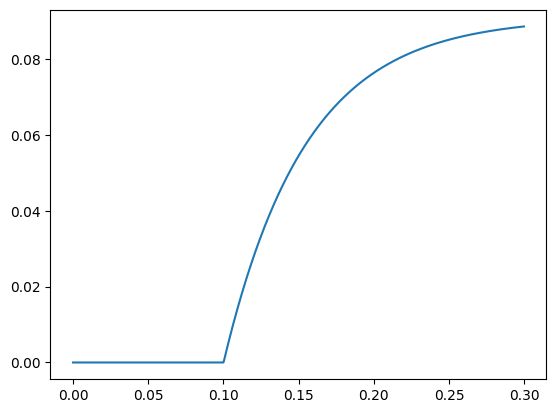

In [9]:
plt.plot(t, yout)